<a href="https://colab.research.google.com/github/risa1796/HOME24/blob/main/Interior_Design_Trends_and_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interior Design Trends and Recommendation

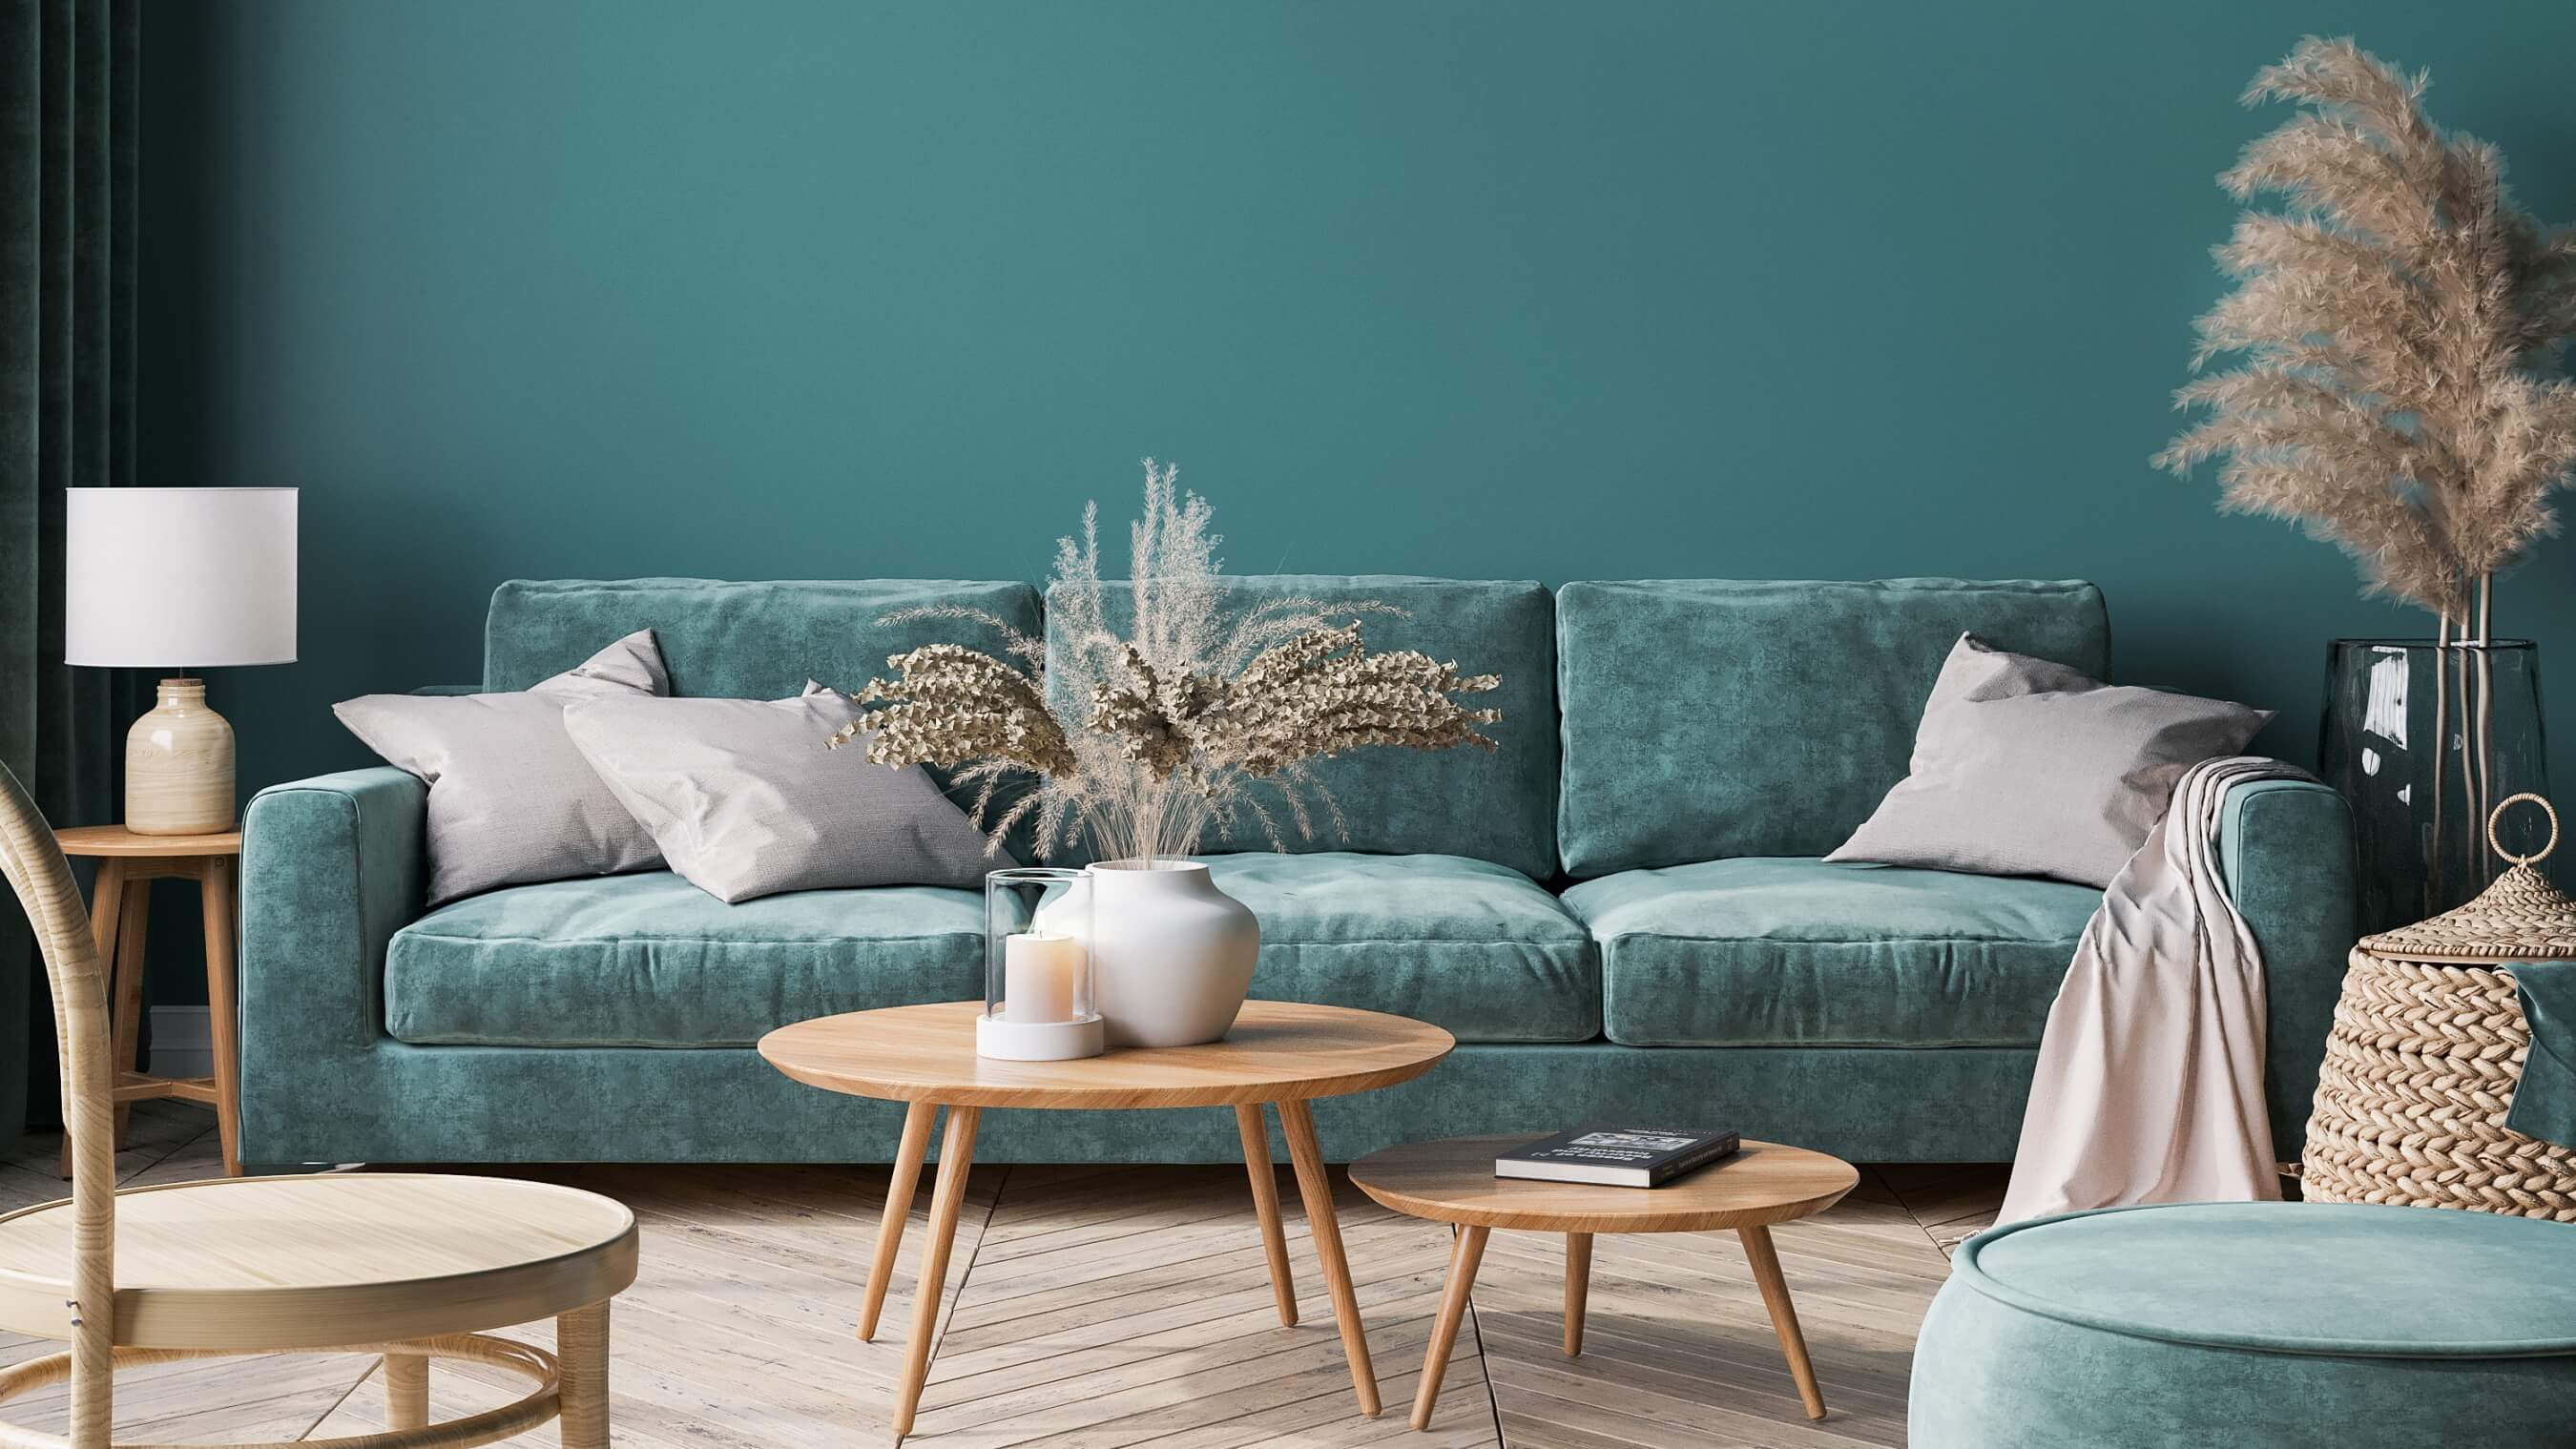

Since I am interested in accomodation and interior design, I wanted to connect this domain with ML and DL. 

In this project, I focused on ...

- Room type classification between bathroom, kitchen and living room
- Detect dominant colors in image
- Clustering similar looks using K-Means
- Find similar looks  using DL and cosine similarity 
- Find matching products(chair) as recommendation

With this project, I wanted to collect recommendation ideas which could enhance the **customer shopping experience** in online website like HOME24. 

Enhancing customer shopping experience is very important because it can lead to longer user's session and reduce bounce rate. Recommendation systems contributes to better shopping experience, which eventually leads to higher sales revenue.

My final goal for this project is a real time recommendation with following steps: 

1. Upload photo of your room
2. AI analyzes the room type and interior style
3. Provide recommendations for the given room type and style.

The only activity required from a customer is uploading his/her room photo.

*Example Scenario:* 

Upload a modern bed room photo → AI analyzes and classify photo as a modern bed room → recommend products for modern style bed room such as modern LED lamp. If one of the dominant colors is yellow, we assume user likes yellow color, so recommend ex. yellow modern carpet.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%cd /content/drive/MyDrive/딥러닝기초/Home24

/content/drive/MyDrive/딥러닝기초/Home24


## Dependencies

In [34]:
device = 'cuda'

In [35]:
!pip install colorthief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from glob import glob
import os 
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from colorthief import ColorThief
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid

from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

from tensorflow.keras.utils import img_to_array

import os
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster
from sklearn import mixture
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

#from yellowbrick.cluster import SilhouetteVisualizer

In [37]:
data_dir = '/content/drive/MyDrive/딥러닝기초/Home24/images'

## Room type classification

### Upload images

In [38]:
classes = os.listdir(data_dir)
classes

['livingroom', 'bathroom', 'kitchen']

-------------livingroom-------------


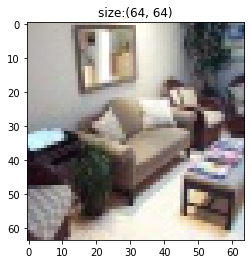

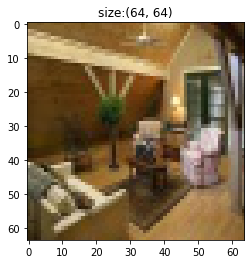

-------------bathroom-------------


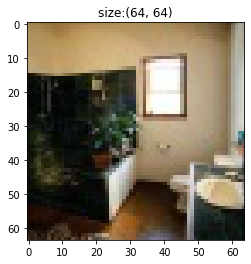

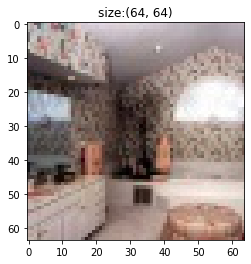

-------------kitchen-------------


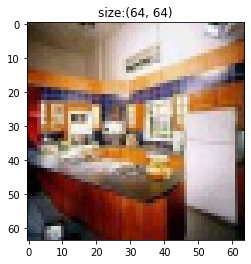

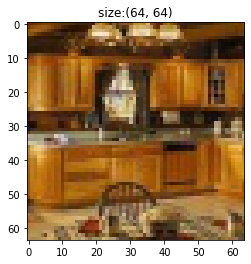

In [39]:
for cl in classes:
  print(f'-------------{cl}-------------')
  image_path = data_dir + '/' + cl + '/'
  image_paths = glob(os.path.join(image_path,  '*'))
  for _ in range(2):
    idx = np.random.randint(0, len(image_paths))
    image = Image.open(image_paths[idx])
    plt.imshow(image)
    plt.title(f'size:{image.size}')
    plt.show() 

In [40]:
transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [41]:
# We apply our transformations using ImageFolder
dataset = ImageFolder(data_dir, transform = transformations)

In [42]:
dataset

Dataset ImageFolder
    Number of datapoints: 385
    Root location: /content/drive/MyDrive/딥러닝기초/Home24/images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

### Split train, validation, test data

In [43]:
train_ratio = int(len(dataset)*0.7)
val_ratio = int(len(dataset)*0.2)
test_ratio = int(len(dataset)*0.1)+1

In [44]:
from torch.utils.data import random_split

train_ds, val_ds, test_ds = random_split(dataset, [train_ratio,val_ratio,test_ratio])
len(train_ds), len(val_ds), len(test_ds)

(269, 77, 39)

In [45]:
tr_values = [item[1] for item in train_ds]

In [46]:
from collections import Counter

Counter(tr_values)

Counter({0: 94, 1: 62, 2: 113})

### Image augmentation

In [47]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [48]:
from torchvision.transforms.transforms import RandomVerticalFlip
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAutocontrast(),
        transforms.RandomAdjustSharpness(0.5),
        transforms.RandomVerticalFlip(0.5)])

In [49]:
train_ds = ApplyTransform(train_ds, transform=data_transforms)
val_ds = ApplyTransform(val_ds, transform=data_transforms)

### Load data batch

In [50]:
batch_size = 25

In [51]:
train_loader = DataLoader(train_ds,
                            batch_size,
                            num_workers = 4,
                            shuffle=True)
val_loader = DataLoader(val_ds,
                         batch_size,
                         num_workers = 4,
                        shuffle=True)

test_loader = DataLoader(test_ds,
                        batch_size,
                        shuffle=False)

In [52]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

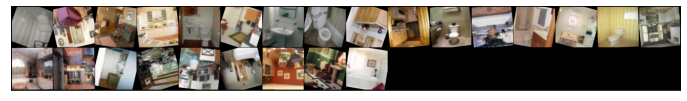

In [53]:
show_batch(val_loader)

### Train Model

In [54]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [55]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [56]:
# Use pretrained GoogLeNet
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet = googlenet.to(device)

In [57]:
googlenet.fc = nn.Linear(1024, 3, device=device)

In [58]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(googlenet.parameters(), lr=1e-3)

In [59]:
N_EPOCH = 10

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(googlenet, train_loader )
    val_loss, val_accuracy = test(googlenet, test_loader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
     Train | Loss :  0.9699, Accuracy :  48.70 %
Validation | Loss :  0.7283, Accuracy :  74.36 %

EPOCH 2
     Train | Loss :  0.6369, Accuracy :  75.09 %
Validation | Loss :  0.5751, Accuracy :  79.49 %

EPOCH 3
     Train | Loss :  0.5402, Accuracy :  78.81 %
Validation | Loss :  0.5773, Accuracy :  79.49 %

EPOCH 4
     Train | Loss :  0.3910, Accuracy :  88.10 %
Validation | Loss :  0.5165, Accuracy :  79.49 %

EPOCH 5
     Train | Loss :  0.3392, Accuracy :  88.85 %
Validation | Loss :  0.4431, Accuracy :  82.05 %

EPOCH 6
     Train | Loss :  0.2406, Accuracy :  93.68 %
Validation | Loss :  0.5391, Accuracy :  76.92 %

EPOCH 7
     Train | Loss :  0.2185, Accuracy :  94.42 %
Validation | Loss :  0.3950, Accuracy :  82.05 %

EPOCH 8
     Train | Loss :  0.1912, Accuracy :  94.05 %
Validation | Loss :  0.4561, Accuracy :  79.49 %

EPOCH 9
     Train | Loss :  0.1464, Accuracy :  97.40 %
Validation | Loss :  0.4516, Accuracy :  79.49 %

EPOCH 10
     Train | Loss :  0.1507,

### Test Model

In [60]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [61]:
True_cnt = 0
False_cnt = 0

for i in range(len(test_ds)):
  img, label = test_ds[i]
  print(img.shape )
  if dataset.classes[label] == predict_image(img, googlenet):
    True_cnt += 1
  else:
    False_cnt += 1

print(f'Model was able to classify {True_cnt} images correctly!')
print(f'Model was wrong {False_cnt} times.')

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([

In [62]:
print(f'{round((False_cnt/(False_cnt+True_cnt))*100)}% of total test dataset were classified wrong.')

21% of total test dataset were classified wrong.


Label: bathroom , Predicted: bathroom


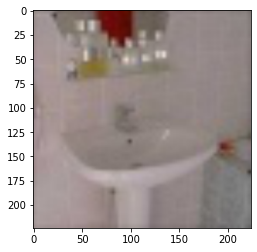

Label: livingroom , Predicted: livingroom


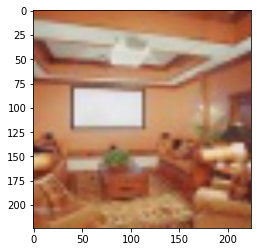

Label: bathroom , Predicted: bathroom


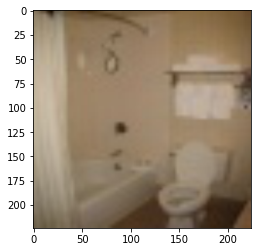

Label: kitchen , Predicted: kitchen


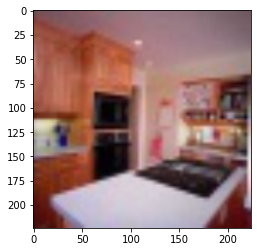

Label: bathroom , Predicted: bathroom


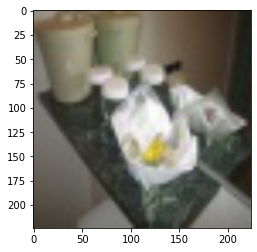

Label: bathroom , Predicted: kitchen


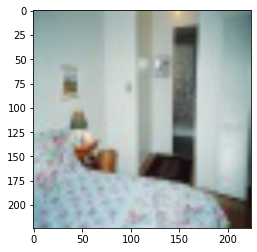

Label: bathroom , Predicted: bathroom


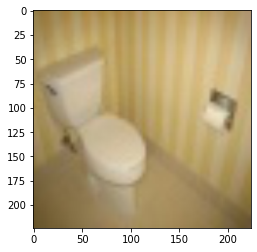

Label: kitchen , Predicted: livingroom


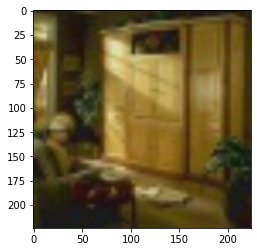

Label: kitchen , Predicted: livingroom


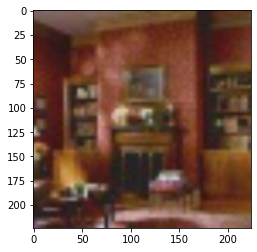

In [66]:
for i in range(11,20):
  img, label = test_ds[i]
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, googlenet))
  plt.imshow(img.permute(1, 2, 0))
  plt.show()

> 데이터터 라벨링 수정 필요!!

### Save Model

In [68]:
torch.save(googlenet.state_dict(), './model_weights.pth')

### Load Model

In [74]:
model = torchvision.models.googlenet(pretrained=True) # we do not specify pretrained=True, i.e. do not load default weights
model.fc = nn.Linear(1024, 3, device=device)
model.load_state_dict(torch.load('./model_weights.pth'))
model = model.to(device)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Detect dominant Colors in image

In [ ]:
for cl in classes:
  print(f'-------------{cl}-------------')
  image_path = data_dir + '/' + cl + '/'
  image_paths = glob(os.path.join(image_path,  '*'))
  for _ in range(2):
    idx = np.random.randint(0, len(image_paths))
    image = Image.open(image_paths[idx])
    plt.imshow(image)
    color_thief = ColorThief(image_paths[idx])
    palette = color_thief.get_palette(color_count=6)
    for i in palette:
      print('RGB Color:', i)

    plt.show() 

## Clustering & Similar images

In [ ]:
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 3 # number of most similar images to retrieve

In [ ]:
full_dir =  data_dir + '/' + 'kitchen' + '/'

In [ ]:
files = [full_dir + x for x in os.listdir(data_dir+ '/' + 'kitchen' + '/') ]

print("number of images:",len(files))

number of images: 100


In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

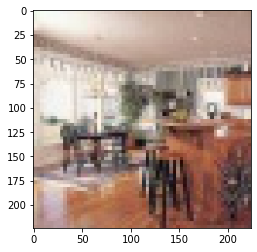

image loaded successfully!


In [ ]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [ ]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [ ]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 1s 889ms/step
features successfully extracted!
number of image features: 4096


array([[1.5038271, 2.8768852, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
# load all the images and prepare them for feeding into the CNN
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

4/4 [==============================] - 4s 407ms/step
features successfully extracted!


(100, 4096)

### Clustering

In [ ]:
features_df = pd.DataFrame(imgs_features, index=files)
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1RIGS7MZ1MN4.jpg,1.503825,2.876880,0.0,0.0,0.000000,0.0,0.0,0.0,3.271208,0.0,...,0.0,0.0,1.592275,0.0,0.0,0.000000,1.968448,0.00000,0.0,0.000000
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/BA1UK7L257S3.jpg,1.988633,3.316052,0.0,0.0,0.000000,0.0,0.0,0.0,0.045519,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.348112,2.347767,0.69526,0.0,0.000000
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/00CBN2E6THZA.jpg,0.891571,1.921764,0.0,0.0,0.000000,0.0,0.0,0.0,0.538705,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.329193,2.985104,0.00000,0.0,0.000000
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1C0ETQ227SZQ.jpg,1.375043,4.051600,0.0,0.0,1.853065,0.0,0.0,0.0,1.761102,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,5.012923,0.00000,0.0,0.391361
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/118VV5ARBCNY.jpg,0.090537,2.651470,0.0,0.0,0.000000,0.0,0.0,0.0,1.930047,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,3.156392,0.00000,0.0,1.239698


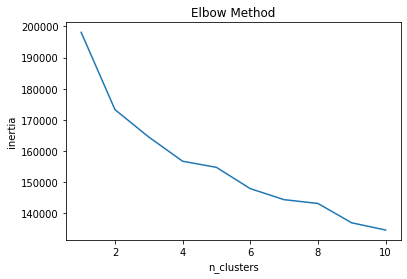

In [ ]:
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(features_df)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [ ]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math


    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)


    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

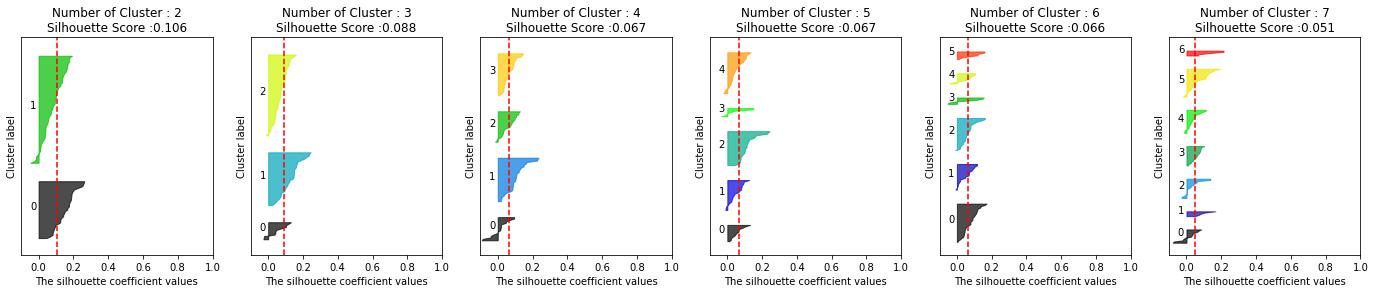

In [ ]:
visualize_silhouette([ 2, 3, 4, 5,6,7], features_df )

In [ ]:
#케이민즈
kmeans = KMeans(n_clusters =2, init='k-means++', max_iter=400, random_state=0).fit(features_df)
features_df['cluster'] = kmeans.labels_
print(kmeans.labels_)

[0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1
 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1]


cluster 0


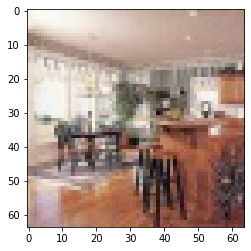

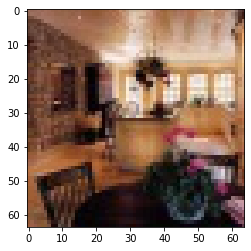

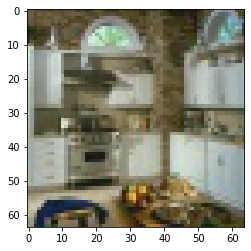

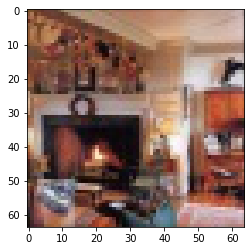

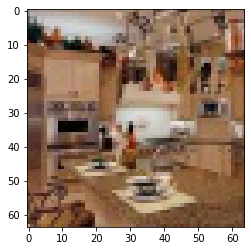

cluster 1


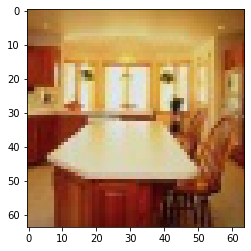

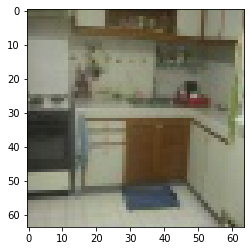

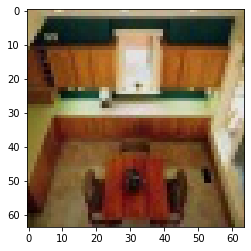

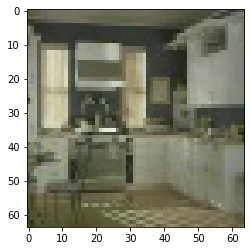

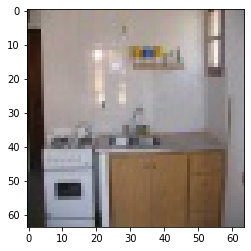

In [ ]:
cluster_df = features_df[['cluster']]
grouped = cluster_df.groupby('cluster')

for i in range(2):
  df = grouped.get_group(i)
  print('cluster',i)
  for x in df.index.tolist()[:5]:
    x = load_img(x)
    plt.imshow(x)
    plt.show()

Rooms in the first cluster seem to have many furniture, patterns and colors. Whereas rooms in the second cluster are more simple and less dynamic. 

### Cosine similarities

Reference code: https://www.kaggle.com/code/jonathanoheix/product-recommendation-based-on-visual-similarity/notebook

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1RIGS7MZ1MN4.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/BA1UK7L257S3.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/00CBN2E6THZA.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1C0ETQ227SZQ.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/118VV5ARBCNY.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/0F2CMXGQ9GSD.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1HNFUXB0VDGD.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/C4FB9HX7Z30A.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/2CEPOVCQV0GH.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1SVG4CXI6PNU.jpg,...,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1TJKKD77OCZ4.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/6TI9PU7ORRR0.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/2FBETDOD00W5.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/2A2ZD2HCNE8S.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1MERRAWNUBAT.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/0I1URYYZCNTG.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/2BNJDTNPZWOJ.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/2_Screenshot-2020-09-09-at-161314.png,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/-methode-times-prod-web-bin-0f8cf95a-df8b-11e9-8221-1b98fc56091e.jpg,/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1-e1589989093873.jpg
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1RIGS7MZ1MN4.jpg,1.000000,0.646804,0.646815,0.567092,0.703929,0.457896,0.632487,0.823676,0.727265,0.817900,...,0.703929,0.559018,0.751789,0.552995,0.600747,0.282945,0.734297,0.345672,0.507668,0.371677
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/BA1UK7L257S3.jpg,0.646804,1.000000,0.625644,0.649303,0.620477,0.541035,0.605154,0.611787,0.547688,0.598064,...,0.620477,0.692247,0.685781,0.665937,0.671836,0.374957,0.668331,0.470446,0.580983,0.484035
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/00CBN2E6THZA.jpg,0.646815,0.625644,1.000000,0.712581,0.732036,0.704007,0.744652,0.609702,0.613226,0.685076,...,0.732036,0.746396,0.685144,0.680746,0.625649,0.566057,0.660698,0.541324,0.589579,0.539465
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/1C0ETQ227SZQ.jpg,0.567092,0.649303,0.712581,1.000000,0.640107,0.647168,0.625423,0.538671,0.489524,0.595829,...,0.640107,0.697755,0.552028,0.606234,0.611804,0.441623,0.601325,0.463472,0.520291,0.451310
/content/drive/MyDrive/딥러닝기초/Home24/images/kitchen/118VV5ARBCNY.jpg,0.703929,0.620477,0.732036,0.640107,1.000000,0.596086,0.754337,0.638673,0.719187,0.632735,...,1.000000,0.679973,0.676684,0.561230,0.608430,0.420413,0.658176,0.394814,0.622126,0.522959


In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


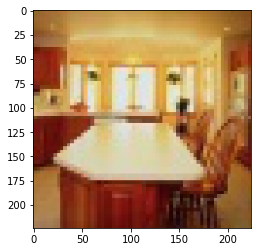

-----------------------------------------------------------------------
most similar products:


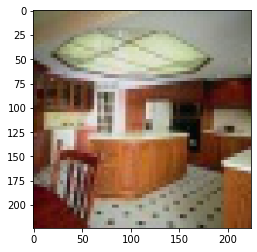

similarity score :  0.7442297


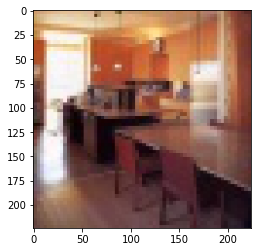

similarity score :  0.72003067


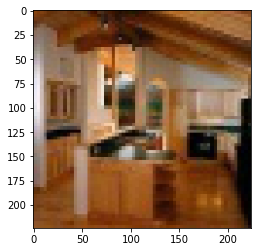

similarity score :  0.7094743


In [ ]:
retrieve_most_similar_products(files[1])

The above images with high similarity scores look pretty similar to the original image due to wood style furniture; braun and white seem to be dominant colors in all images.  

## Yolov5



In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5/
%pip install -qr requirements.txt 

import yaml
import torch
from IPython.display import Image, clear_output

print(f"Torch:{torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda. is_available() else 'CPU'})")
     

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/딥러닝기초/Home24/yolov5
Torch:1.13.1+cu116 (Tesla T4)


In [ ]:
!python detect.py --weight yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/4 /content/drive/MyDrive/딥러닝기초/Home24/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 12.4ms
image 2/4 /content/drive/MyDrive/딥러닝기초/Home24/yolov5/data/images/room.jpg: 448x640 1 person, 4 chairs, 5 potted plants, 1 dining table, 1 vase, 12.1ms
image 3/4 /content/drive/MyDrive/딥러닝기초/Home24/yolov5/data/images/room.png: 448x640 3 couchs, 1 potted plant, 1 dining table, 1 

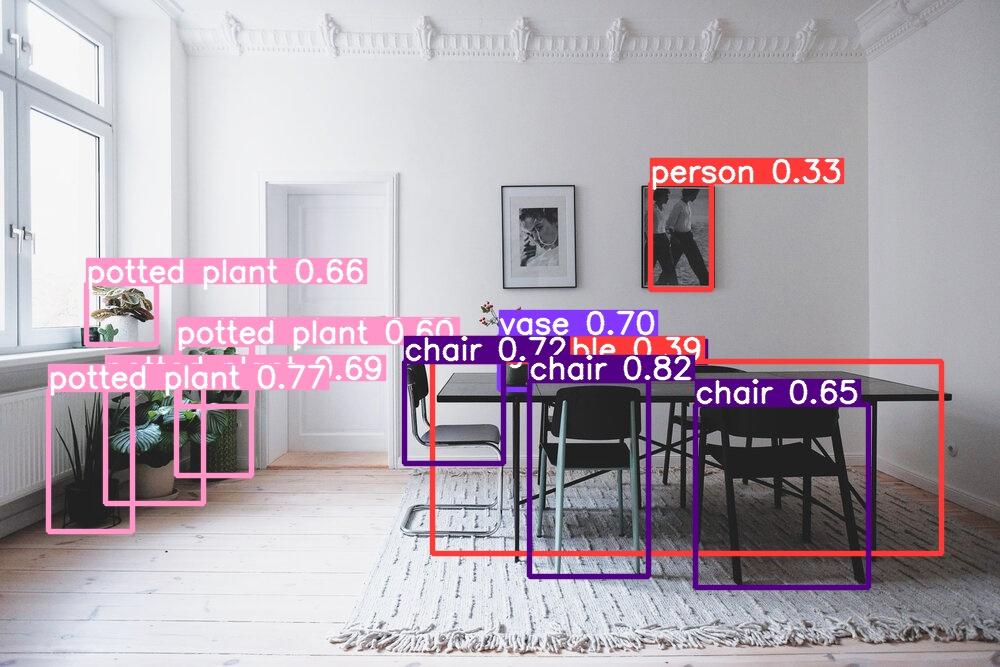

In [ ]:
Image(filename='runs/detect/exp6/room.jpg',width=600)

In [ ]:
img = '/content/drive/MyDrive/딥러닝기초/Home24/yolov5/runs/detect/exp6/room.jpg'

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

img =  Image.open(img)

In [ ]:
# Convert the PIL image to Tensor
img = ToTensor()(img).unsqueeze(0)
# print the converted Torch tensor
print(img)
print("dtype of tensor:",img.dtype)

tensor([[[[0.9490, 0.9059, 0.8235,  ..., 0.5686, 0.5647, 0.5569],
          [0.9451, 0.9020, 0.8196,  ..., 0.5608, 0.5569, 0.5529],
          [0.9412, 0.8980, 0.8196,  ..., 0.5686, 0.5686, 0.5686],
          ...,
          [0.5255, 0.5020, 0.5098,  ..., 0.4000, 0.3922, 0.4039],
          [0.5373, 0.5176, 0.5333,  ..., 0.4510, 0.4353, 0.4471],
          [0.5961, 0.5804, 0.6000,  ..., 0.4863, 0.4706, 0.4667]],

         [[0.9647, 0.9216, 0.8431,  ..., 0.5647, 0.5608, 0.5608],
          [0.9608, 0.9176, 0.8392,  ..., 0.5569, 0.5608, 0.5569],
          [0.9569, 0.9137, 0.8392,  ..., 0.5725, 0.5725, 0.5725],
          ...,
          [0.5412, 0.5216, 0.5176,  ..., 0.3490, 0.3373, 0.3490],
          [0.5529, 0.5333, 0.5412,  ..., 0.3961, 0.3804, 0.3843],
          [0.6118, 0.5961, 0.6078,  ..., 0.4314, 0.4039, 0.4000]],

         [[0.9686, 0.9333, 0.8588,  ..., 0.5882, 0.5843, 0.5804],
          [0.9647, 0.9294, 0.8549,  ..., 0.5804, 0.5804, 0.5765],
          [0.9608, 0.9255, 0.8549,  ..., 0

In [ ]:
img = img.resize_(224, 224)

In [ ]:
predict_image(img, googlenet)

'kitchen'

> The image is classified as kitchen

In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Image
img = '/content/drive/MyDrive/딥러닝기초/Home24/yolov5/data/images/room.jpg'

# Inference
results = model(img)

results.pandas().xyxy[0]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-24 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


,xmin,ymin,xmax,ymax,confidence,class,name
0,529.000732,379.703705,648.474976,576.160339,0.819799,56,chair
1,47.522125,389.346985,132.365997,530.759888,0.774295,58,potted plant
2,403.608551,360.784637,503.208679,462.783722,0.720456,56,chair
3,499.050537,335.385284,529.716003,389.192963,0.699949,75,vase
4,104.595818,380.234680,202.795837,503.237213,0.686290,58,potted plant
5,85.846886,282.914062,155.600342,343.906921,0.664731,58,potted plant
6,694.651489,403.522400,867.822632,587.196045,0.652628,56,chair
7,175.856476,343.558929,250.926712,475.347290,0.597558,58,potted plant
8,431.728455,361.030518,940.979126,553.318237,0.389461,60,dining table
9,650.456360,183.309311,711.096130,289.266724,0.334606,0,person


In [ ]:
df = results.pandas().xyxy[0]
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,529.000732,379.703705,648.474976,576.160339,0.819799,56,chair
1,47.522125,389.346985,132.365997,530.759888,0.774295,58,potted plant
2,403.608551,360.784637,503.208679,462.783722,0.720456,56,chair
3,499.050537,335.385284,529.716003,389.192963,0.699949,75,vase
4,104.595818,380.234680,202.795837,503.237213,0.686290,58,potted plant
5,85.846886,282.914062,155.600342,343.906921,0.664731,58,potted plant
6,694.651489,403.522400,867.822632,587.196045,0.652628,56,chair
7,175.856476,343.558929,250.926712,475.347290,0.597558,58,potted plant
8,431.728455,361.030518,940.979126,553.318237,0.389461,60,dining table
9,650.456360,183.309311,711.096130,289.266724,0.334606,0,person


object index: 8


-1

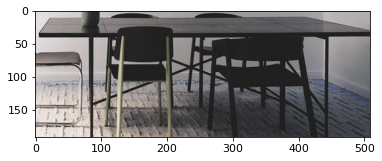

In [ ]:
import cv2
#from google.colab.patches import cv2_imshow

# Visualizing the data
color = (0, 0, 255) # RED

obj_idx = input('object index: ')

xmin, ymin, xmax, ymax = df.iloc[int(obj_idx),:4]
image_path = '/content/drive/MyDrive/딥러닝기초/Home24/yolov5/data/images/room.jpg'
image = cv2.imread(image_path)
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

crop_img = image[int(ymin):int(ymax),int(xmin):int(xmax)]
crop_img
plt.imshow(crop_img)

#cv2.rectangle(image, pt1, pt2, color)
#cv2_imshow(image)
cv2.waitKey()

In [ ]:
cv2.imwrite('/content/drive/MyDrive/딥러닝기초/Home24/data/target.png', crop_img)

True

### Matching products recommendation (Chair)

In [ ]:
data_dir = '/content/drive/MyDrive/딥러닝기초/Home24/data/'

In [ ]:
files = [data_dir + x for x in os.listdir(data_dir+ '/') ]

print("number of images:",len(files))

number of images: 127


In [ ]:
files[0]

'/content/drive/MyDrive/딥러닝기초/Home24/data/AEAI9YZE4X2S.jpg'

In [ ]:
# load all the images and prepare them for feeding into the CNN
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

4/4 [==============================] - 3s 1s/step
features successfully extracted!


(127, 4096)

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/MyDrive/딥러닝기초/Home24/data/AEAI9YZE4X2S.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/8GIRRG1VCUUZ.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/9DGR6RDAYRXO.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/BNV1762C9WT7.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/3AJRE4MFXIAE.jpg,...,/content/drive/MyDrive/딥러닝기초/Home24/data/6G13RZG7F50L.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/ZQAOHEQYPS1U.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/6LPZVWVLDJGE.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/D7NDMV7N49LY.jpg,/content/drive/MyDrive/딥러닝기초/Home24/data/target.png
/content/drive/MyDrive/딥러닝기초/Home24/data/AEAI9YZE4X2S.jpg,1.000000,0.325693,0.330420,0.426324,0.299628,...,0.318348,0.239921,0.249504,0.371596,0.358991
/content/drive/MyDrive/딥러닝기초/Home24/data/8GIRRG1VCUUZ.jpg,0.325693,1.000000,0.191907,0.305019,0.216197,...,0.335469,0.304443,0.224940,0.288835,0.235320
/content/drive/MyDrive/딥러닝기초/Home24/data/9DGR6RDAYRXO.jpg,0.330420,0.191907,1.000000,0.283057,0.425935,...,0.469001,0.361375,0.411143,0.278601,0.329159
/content/drive/MyDrive/딥러닝기초/Home24/data/BNV1762C9WT7.jpg,0.426324,0.305019,0.283057,1.000000,0.514968,...,0.514684,0.419885,0.330118,0.583267,0.266941
/content/drive/MyDrive/딥러닝기초/Home24/data/3AJRE4MFXIAE.jpg,0.299628,0.216197,0.425935,0.514968,1.000000,...,0.532989,0.456666,0.526386,0.446595,0.421266


In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_matching_products(given_img):

    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

In [ ]:
nb_closest_images = 1

most similar products:
similarity score :  0.5455554


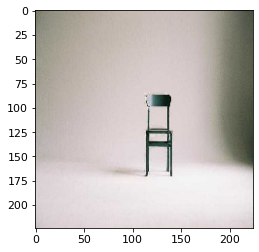

In [ ]:
retrieve_most_matching_products(files[-1])

For black table a black simple chair seems to match perfectly together! 